In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from copy import deepcopy    
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'font.size':25});
plt.rcParams.update({'axes.linewidth':1.5})
plt.rc('lines',linewidth=3);

from preprocess import *
from dmd import *
from sensor_placement import *

### In this tutorial, we will download publicly available data from Gene Expression Omnibus (GEO) and apply our developed methology (DMD - Observability Analysis) to the obtained time-course RNA-seq measurements. The data are from yeast cell-cycle transcriptomic profiling and consist of data from over 10,000 unique transcripts (this is high-dimensional and as a disclaimer, DMD and observability analysis will take a few minutes to run)

Download time-course RNA-seq data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE8799
(already in data directory of the git repository). 

From the associate manuscript: 
"To determine the extent to which the global cell cycle transcription program is controlled by cyclin/CDK complexes, we examined genome-wide transcription dynamics in budding yeast mutant cells that do not express S-phase and mitotic cyclins."

In [119]:
df = pd.read_csv('data/GSE8799_series_matrix.txt',sep='\t')
ids = list(df['ID_REF'])
df.head()

,ID_REF,GSM218597,GSM218598,GSM218599,GSM218600,GSM218601,GSM218602,GSM218603,GSM218604,GSM218605,...,GSM218647,GSM218648,GSM218649,GSM218650,GSM218651,GSM218652,GSM218653,GSM218654,GSM218655,GSM218656
0,1769308_at,3026.500862,2252.171796,1975.478654,1665.481422,1697.474909,2168.868673,2160.200687,1742.859325,1735.900066,...,1921.814073,1937.786306,1858.287732,1650.368950,1795.433819,1778.913939,2032.390460,1789.345165,1778.092088,1848.756973
1,1769309_at,546.340140,512.886257,623.860251,666.480333,640.297172,938.828475,941.755685,714.037040,619.336666,...,595.364572,618.893618,517.241568,566.228112,537.662725,558.977447,633.099838,651.399488,614.895256,603.174345
2,1769310_at,245.006132,262.831409,303.649031,300.232348,272.038320,292.785199,288.931500,267.742659,269.388497,...,262.547612,279.992447,254.900818,249.533689,253.279819,253.446820,268.746487,267.809083,250.120212,236.109976
3,1769311_at,2889.750940,3640.789146,5053.186616,6826.320166,7881.647630,7699.647622,6209.735920,5017.770931,5004.340884,...,8124.781526,7107.818751,5948.723750,5194.401260,5104.409467,5135.853019,5525.455307,5753.819517,5945.917875,6126.174538
4,1769312_at,1700.918825,993.146755,997.666423,984.453335,993.899779,985.662645,1116.013991,1250.333881,1311.541959,...,954.610932,960.949982,986.712839,989.793049,924.937811,934.083174,907.945822,937.475317,872.169857,776.651483


### Split the dataset into wild-type and mutant 

In [120]:
wt_df = df.iloc[:,1:df.shape[1]//2+1]
mt_df = df.iloc[:,list(np.arange(31,df.shape[1]))]

### log transform -- we want the magnitude of expression to not impact the connectivity between genes 

In [121]:
wt_df = np.log2(wt_df)
mt_df = np.log2(mt_df)

### Reshape into 3D tensor (genes x time points x replicates)


In [122]:
wt_df = np.array(wt_df).reshape(len(wt_df),15,2) # 15 timepoints, 2 replicates
mt_df = np.array(mt_df).reshape(len(wt_df),15,2) # 15 timepoints, 2 replicates

### dynamic mode decomposition

In [123]:
r = 10 # number of dynamic modes
A_wt,A_wt_red,wt_red,U_wt,_,eVals_r_wt,eVecs_r_wt,Phi_wt,b_r0_wt,b_r1_wt = \
        dmd(wt_df,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3)

r2_score for n-step prediction (reduced): 3.534e-01


In [124]:
r = 10 # number of dynamic modes
A_mt,A_mt_red,mt_red,U_mt,_,eVals_r_mt,eVecs_r_mt,Phi_mt,b_r0_mt,b_r1_mt = \
        dmd(mt_df,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3)

r2_score for n-step prediction (reduced): 6.047e-01


### Visualize the eigenvalues and modes

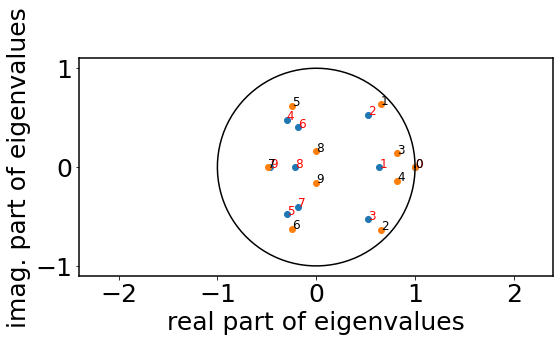

In [125]:
plt.figure(figsize=(8.5,4))
theta = np.linspace(0,2*np.pi,200)
plt.plot(np.cos(theta),np.sin(theta),c='black',lw=1.5)
plt.scatter(np.real(eVals_r_wt), np.imag(eVals_r_wt))
for ii, e in enumerate(eVals_r_wt):
    plt.text(np.real(e), np.imag(e), str(ii), color="red", fontsize=12)
plt.scatter(np.real(eVals_r_mt), np.imag(eVals_r_mt))
for ii, e in enumerate(eVals_r_mt):
    plt.text(np.real(e), np.imag(e), str(ii), color="k", fontsize=12)
plt.xlabel('real part of eigenvalues'); plt.ylabel('imag. part of eigenvalues')
plt.axis('equal')
plt.show()

The wild-type and mutant spectrum are very similar. Note that the eigenvalue at (1,0) is representing the mean of the data. Had it been subtracted (leave that option up to the user), this mode would not appear. 

Let's check their modes to see how similar they are.

In [126]:
mode_evol = np.zeros((len(eVals_r_wt),wt_df.shape[1]),dtype=complex)
for ii in range(1,wt_df.shape[1]+1):
    mode_evol[:,ii-1] = eVals_r_wt**ii

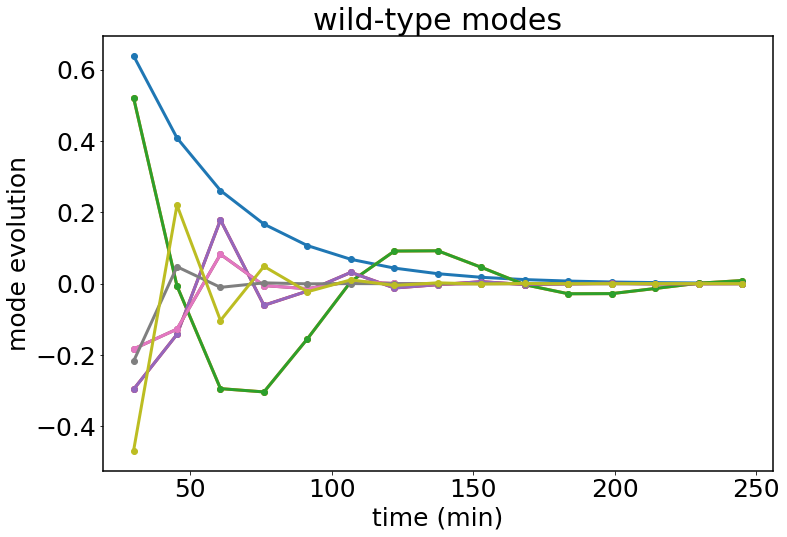

In [127]:
plt.figure(figsize=(12,8))
plt.title("wild-type modes")
plt.plot(np.linspace(30,245,15),np.real(mode_evol)[1:].T,'o-') # skipping the mean mode
plt.xlabel('time (min)'); plt.ylabel('mode evolution')
plt.show()

In [128]:
mode_evol = np.zeros((len(eVals_r_mt),wt_df.shape[1]),dtype=complex)
for ii in range(1,wt_df.shape[1]+1):
    mode_evol[:,ii-1] = eVals_r_mt**ii

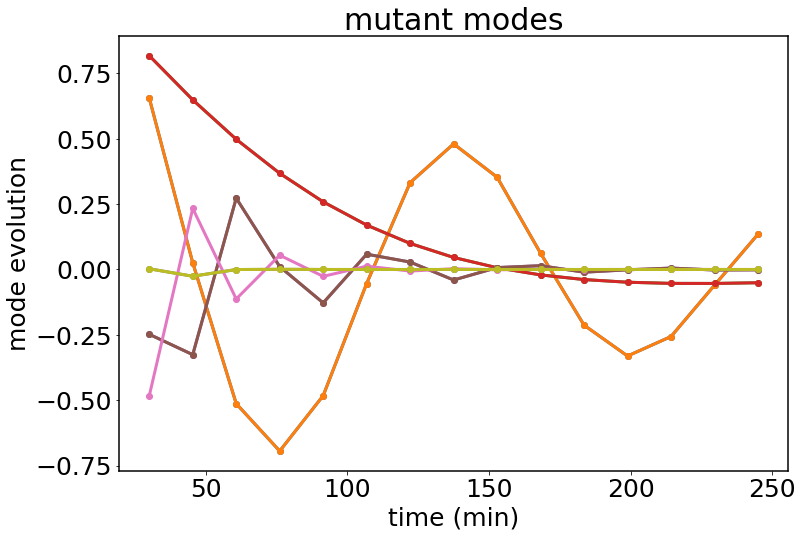

In [129]:
plt.figure(figsize=(12,8))
plt.title("mutant modes")
plt.plot(np.linspace(30,245,15),np.real(mode_evol)[1:].T,'o-')
plt.xlabel('time (min)'); plt.ylabel('mode evolution')
plt.show()

The wild-type modes are aligned with those obtained in: https://academic.oup.com/biomethods/article/5/1/bpaa018/5901534#supplementary-data in which the author performed DMD on yeast cell cycle transcriptomics data.

Note the convergence to zero for all modes. This is due to the exponential stability of the modes which can be seen by the magnitude of the corresponding eigenvalues. 


One could try to identify dynamically important genes by clustering genes by mode in each dataset (wild-type vs. mutant) and identifying which genes are disrupted in these clusters in the transition from wild-type to mutant. One could also look at specific frequency responses to describe how the cell-cycle is disrupted in the mutant case. 

## Observability maximization
As the data matrix is high-dimensional (O(10^4)), we will only construct the reduced order observability gramian and use this matrix to estimate the gene sampling weights that rank each gene by their contribution to observability. We will do this for both datasets separately and compare the rankings. 

In [130]:
nT = 15 
G_wt, G_recon_wt = gram_matrix(A_wt_red,wt_red[:,0,:],nT=nT,reduced=True,projection_matrix=U_wt)
G_mt, G_recon_mt = gram_matrix(A_mt_red,mt_red[:,0,:],nT=nT,reduced=True,projection_matrix=U_mt)

We need the leading right eigenvector of the gramian (a symmetric matrix) -- these are gene sampling weights

In [131]:
D_wt, V_wt = sp.linalg.eig(G_wt,left=False,right=True)
D_mt, V_mt = sp.linalg.eig(G_mt,left=False,right=True)

Project the low-dim eigenvectors back to original high-dim for ranking visualization

In [132]:
w_wt = (U_wt @ V_wt)[:,0]
rank_wt = np.argsort(w_wt)
w_mt = (U_mt @ V_mt)[:,0]

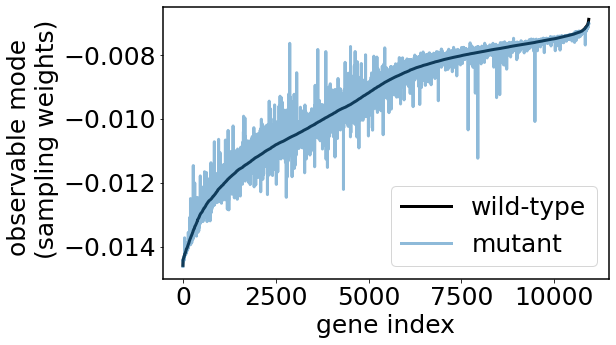

In [165]:
plt.figure(figsize=(8,5))
plt.plot(w_wt[rank_wt],label='wild-type',c='k')
plt.plot(w_mt[rank_wt],label='mutant',alpha=0.5)
plt.ylabel('observable mode \n (sampling weights)')
plt.xlabel('gene index')
plt.legend()
plt.show()

The observable mode trends are quite similar. However there is signicant difference in the ranking of the genes overall. This provides a good basis for investigation of gene sets (say by selecting the top 1000 observable genes and identifying differences based on condition) 

Let's plot the top gene for each of wild-type and mutant cases

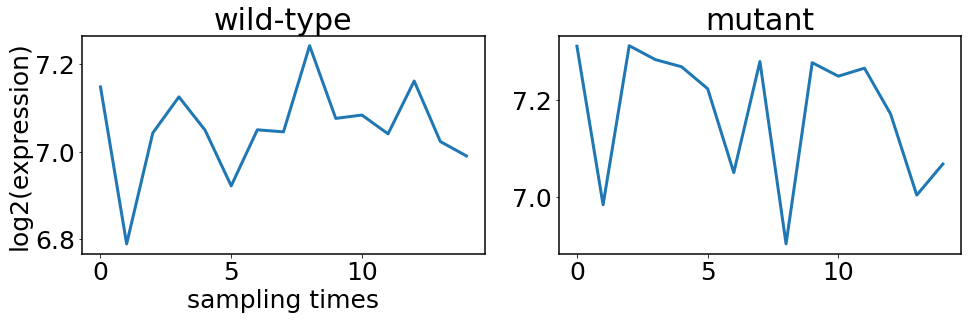

In [136]:
fig, ax = plt.subplots(1,2,figsize=(14,5),sharex=True,sharey=False)
ax[0].set_title('wild-type')
ax[0].plot(np.mean(wt_df[rank_wt[-1]],axis=1))
ax[1].set_title('mutant')
ax[1].plot(np.mean(mt_df[rank_wt[-1]],axis=1))
ax[0].set_xlabel('sampling times')
ax[0].set_ylabel('log2(expression)')
plt.tight_layout()
plt.show()

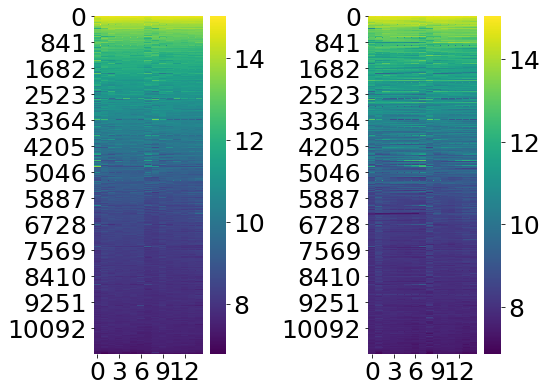

In [146]:
# sort genes by observability rank and plot heatmap of dynamics
fig,ax = plt.subplots(1,2,figsize=(8,6))
sns.heatmap(wt_df[np.argsort((w_wt))].mean(axis=2),cmap='viridis',ax=ax[0])
sns.heatmap(mt_df[np.argsort((w_wt))].mean(axis=2),cmap='viridis',ax=ax[1])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/site-packages/matplotlib/collections.py:202: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


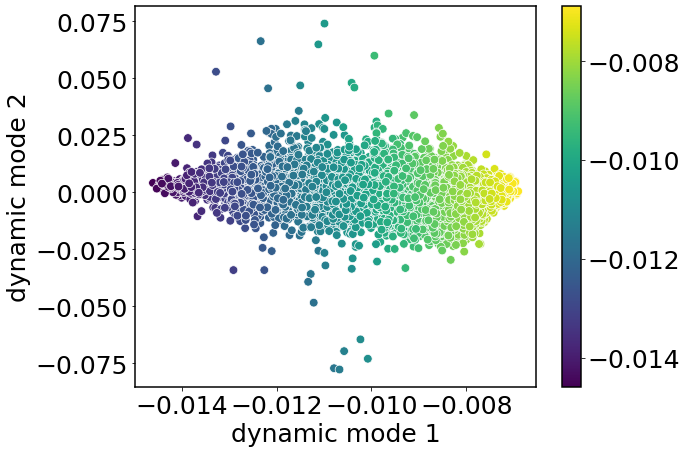

In [168]:
fig, ax = plt.subplots(figsize=(9,7))
sns.scatterplot(x=Phi_wt[:,0],y=Phi_wt[:,1],c=(w_wt),ax=ax,s=75)
plt.xlabel('dynamic mode 1'); plt.ylabel('dynamic mode 2');

norm = plt.Normalize((w_wt).min(), (w_wt).max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm)
plt.show()

## We will now re-do the calculations, but on the fold-change response of the two conditions (mutant / wild-type)

In [3]:
wt_df = df.iloc[:,1:df.shape[1]//2+1]
mt_df = df.iloc[:,list(np.arange(31,df.shape[1]))]
wt_df = np.array(wt_df).reshape(len(wt_df),15,2) # 15 timepoints, 2 replicates
mt_df = np.array(mt_df).reshape(len(wt_df),15,2) # 15 timepoints, 2 replicates

In [209]:
fc = mt_df / wt_df
fc_orig = deepcopy(fc)

In [5]:
r = 20 # number of dynamic modes
A,A_red,fc_red,U,_,eVals_r,eVecs_r,Phi,_,_ = \
        dmd(fc,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3)

r2_score for n-step prediction (reduced): 5.133e-01


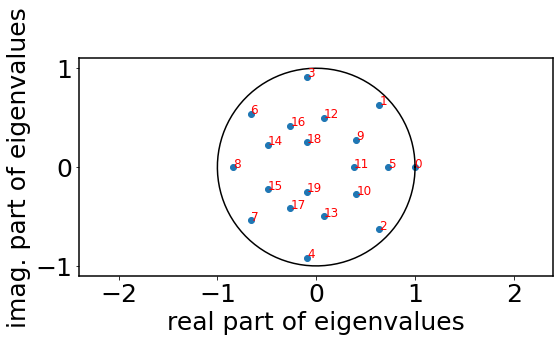

In [39]:
plt.figure(figsize=(8.5,4))
theta = np.linspace(0,2*np.pi,200)
plt.plot(np.cos(theta),np.sin(theta),c='black',lw=1.5)
plt.scatter(np.real(eVals_r), np.imag(eVals_r))
for ii, e in enumerate(eVals_r):
    plt.text(np.real(e), np.imag(e), str(ii), color="red", fontsize=12)
plt.xlabel('real part of eigenvalues'); plt.ylabel('imag. part of eigenvalues')
plt.axis('equal')
plt.show()

In [7]:
mode_evol = np.zeros((len(eVals_r),fc.shape[1]),dtype=complex)
for ii in range(1,fc.shape[1]+1):
    mode_evol[:,ii-1] = eVals_r**ii

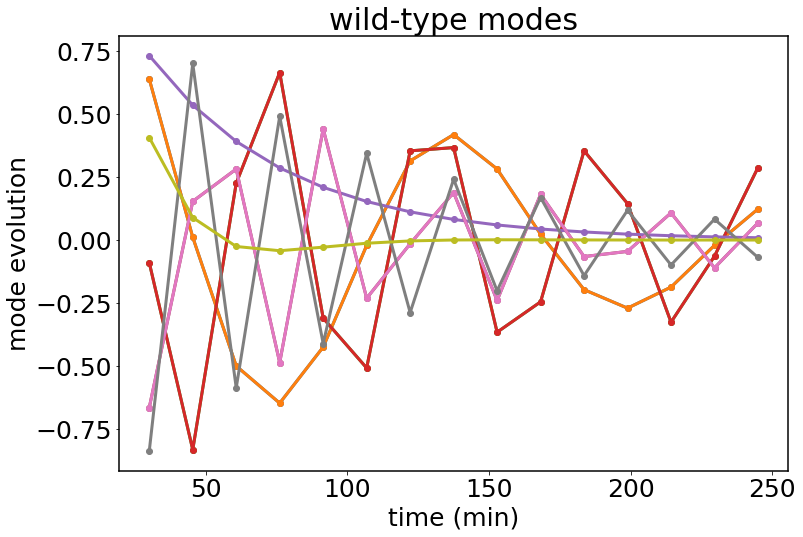

In [8]:
plt.figure(figsize=(12,8))
plt.title("fc modes")
plt.plot(np.linspace(30,245,15),np.real(mode_evol)[1:10].T,'o-') # skipping the mean mode
plt.xlabel('time (min)'); plt.ylabel('mode evolution')
plt.show()

DMD is able to capture the oscillatory dynamics of the cell-cycle and split into important frequencies

### Fold change observability analysis

In [64]:
nT = 15 
G, _ = gram_matrix(A_red,fc_red[:,0,:],nT=nT,reduced=True,projection_matrix=U)

In [65]:
D, V = sp.linalg.eig(G,left=False,right=True)

In [66]:
w = (U @ V)[:,0] 

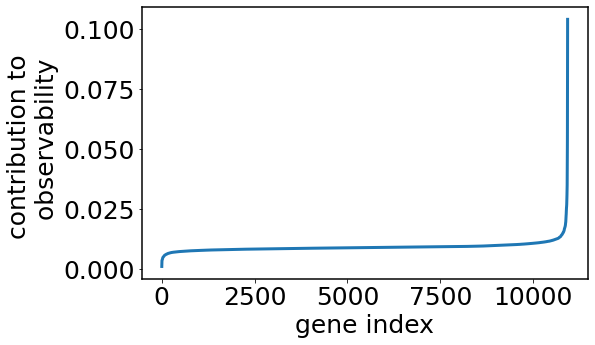

In [68]:
plt.figure(figsize=(8,5))
plt.plot(np.sort(np.abs(w)))
plt.xlabel('gene index')
plt.ylabel('contribution to \n observability')
plt.show()

Observability analysis is able to separate out a few genes that contribute highly to observability 

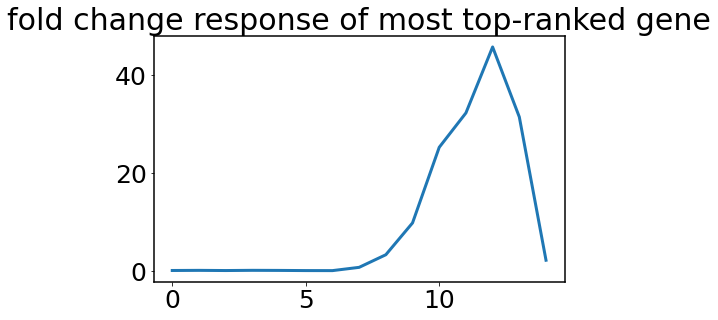

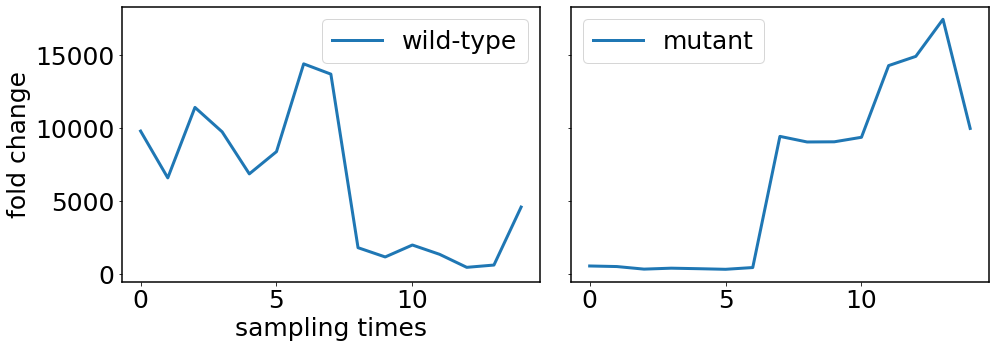

In [71]:
plt.figure(figsize=(7,5))
plt.title('fold change response of most top-ranked gene')
plt.plot(np.mean(fc[np.argsort(np.abs(w))[-1]],axis=1),label='wild-type')
plt.xlabel('sampling times')
plt.ylabel('fold change')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2,figsize=(14,5),sharex=True,sharey=True)
ax[0].plot(np.mean(wt_df[np.argsort(np.abs(w))[-1]],axis=1),label='wild-type')
ax[1].plot(np.mean(mt_df[np.argsort(np.abs(w))[-1]],axis=1),label='mutant')
plt.tight_layout()
ax[0].set_xlabel('sampling times')
ax[0].set_ylabel('expression')
ax[0].legend()
ax[1].legend()
plt.show()



Genes that contribute highly to observability (top-ranked plotted above) when considering the fold-change response, are those that are dysregulated across time and are able to recapitulate the cell state (see main.ipynb or manuscript for more information on cell state reconstruction)

<AxesSubplot:>

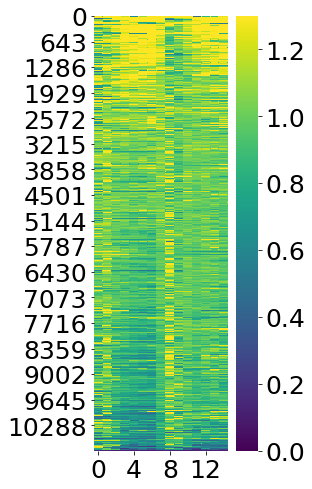

In [95]:
# sort genes by observability rank and plot heatmap of dynamics
plt.figure(figsize=(3,8))
sns.heatmap(fc[np.argsort((w))].mean(axis=2),cmap='viridis',vmin=0,vmax=1.3)

/usr/local/lib/python3.8/site-packages/matplotlib/collections.py:202: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


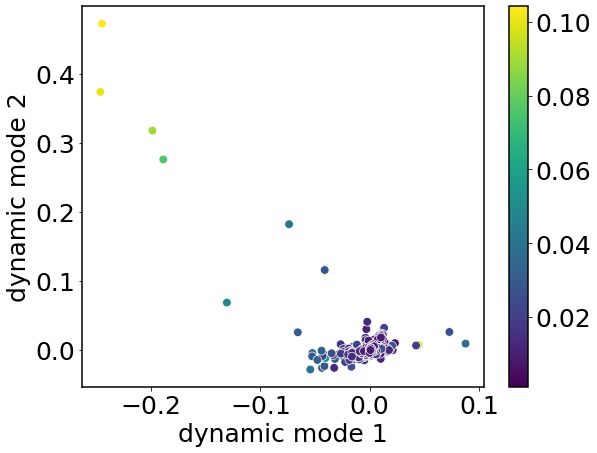

In [147]:
fig, ax = plt.subplots(figsize=(9,7))
sns.scatterplot(x=Phi[:,1],y=Phi[:,8],c=np.abs(w),ax=ax,s=75)
plt.xlabel('dynamic mode 1'); plt.ylabel('dynamic mode 8');

norm = plt.Normalize(np.abs(w).min(), np.abs(w).max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm)
plt.show()

### Finally, let's see how results change when we standardize the fold change response of each gene

In [210]:
fc_long = fc.reshape(len(fc),fc.shape[1]*fc.shape[2],order='F') 
fc_long = (fc_long - np.mean(fc_long,axis=1)[:,np.newaxis])/np.std(fc_long,axis=1)[:,np.newaxis]
fc = fc_long.reshape(len(fc),fc.shape[1],fc.shape[2],order='F')

In [211]:
r = 28 # number of dynamic modes
A,A_red,fc_red,U,_,eVals_r,eVecs_r,Phi,_,_ = \
        dmd(fc,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3)

r2_score for n-step prediction (reduced): 1.000e+00


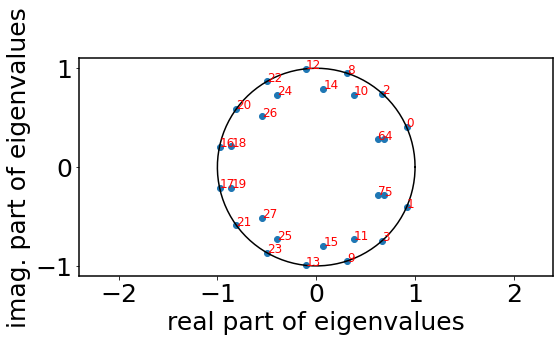

In [212]:
plt.figure(figsize=(8.5,4))
theta = np.linspace(0,2*np.pi,200)
plt.plot(np.cos(theta),np.sin(theta),c='black',lw=1.5)
plt.scatter(np.real(eVals_r), np.imag(eVals_r))
for ii, e in enumerate(eVals_r):
    plt.text(np.real(e), np.imag(e), str(ii), color="red", fontsize=12)
plt.xlabel('real part of eigenvalues'); plt.ylabel('imag. part of eigenvalues')
plt.axis('equal')
plt.show()

In [213]:
mode_evol = np.zeros((len(eVals_r),fc.shape[1]),dtype=complex)
for ii in range(1,fc.shape[1]+1):
    mode_evol[:,ii-1] = eVals_r**ii

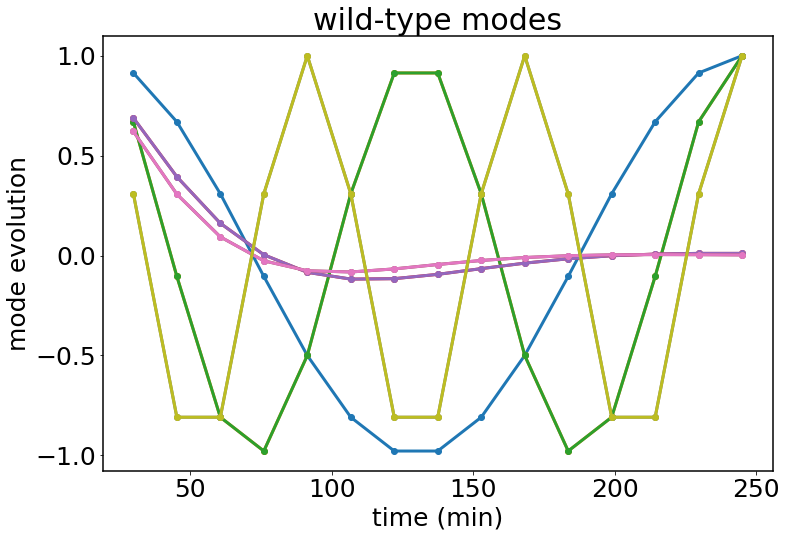

In [214]:
plt.figure(figsize=(12,8))
plt.title("wild-type modes")
plt.plot(np.linspace(30,245,15),np.real(mode_evol)[1:10].T,'o-') # skipping the mean mode
plt.xlabel('time (min)'); plt.ylabel('mode evolution')
plt.show()

starting to appear that we are recovering a fourier basis, if we extend the number of modes r to be equal to number of total time points, we should recover it completely. (try setting r=28 above if it isn't already set)

In [215]:
nT = 15 
G, _ = gram_matrix(A_red,fc_red[:,0,:],nT=nT,reduced=True,projection_matrix=U)
D, V = sp.linalg.eig(G,left=False,right=True)
w = (U @ V)[:,0] 

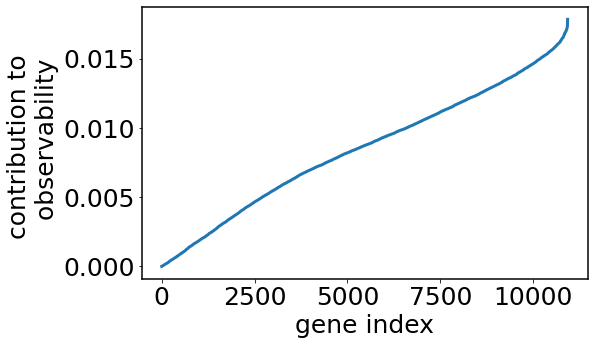

In [216]:
plt.figure(figsize=(8,5))
plt.plot(np.sort(np.abs(w)))
plt.xlabel('gene index')
plt.ylabel('contribution to \n observability')
plt.show()

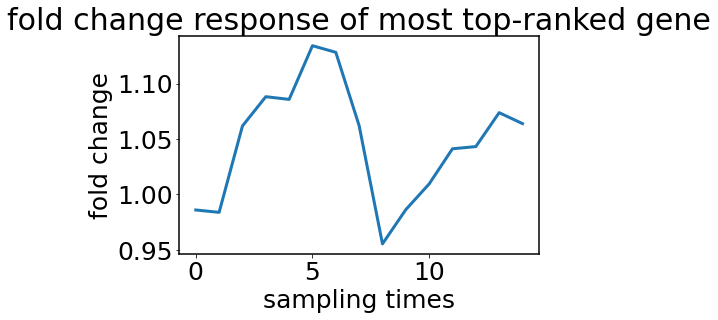

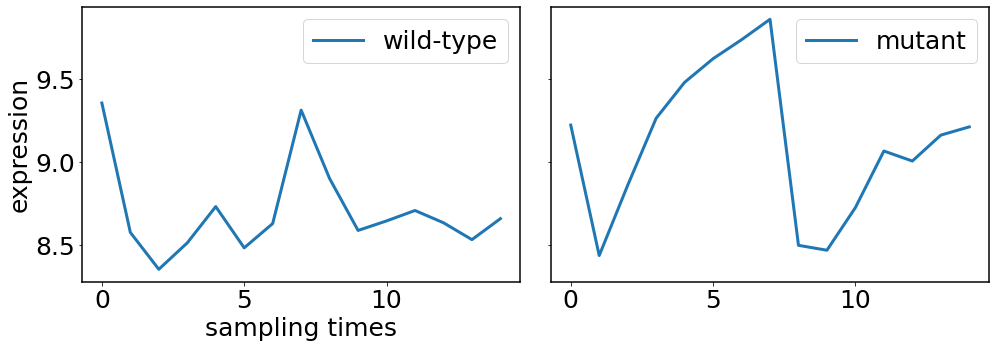

In [230]:
plt.figure(figsize=(7,5))
plt.title('fold change response of most top-ranked gene')
plt.plot(np.mean(fc_orig[np.argsort(np.abs(w))[-1]],axis=1),label='wild-type')
plt.xlabel('sampling times')
plt.ylabel('fold change')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2,figsize=(14,5),sharex=True,sharey=True)
ax[0].plot(np.mean(wt_df[np.argsort(np.abs(w))[-1]],axis=1),label='wild-type')
ax[1].plot(np.mean(mt_df[np.argsort(np.abs(w))[-1]],axis=1),label='mutant')
plt.tight_layout()
ax[0].set_xlabel('sampling times')
ax[0].set_ylabel('expression')
ax[0].legend()
ax[1].legend()
plt.show()



<AxesSubplot:>

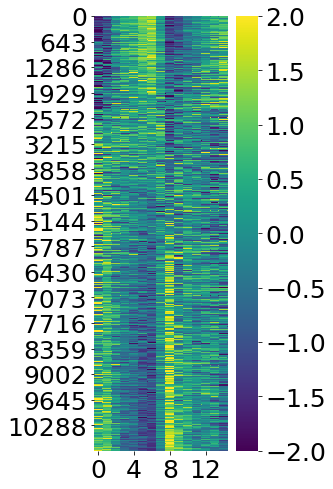

In [238]:
# sort genes by observability rank and plot heatmap of dynamics
plt.figure(figsize=(3,8))
sns.heatmap(fc[np.argsort((w))].mean(axis=2),cmap='viridis',vmin=-2,vmax=2)

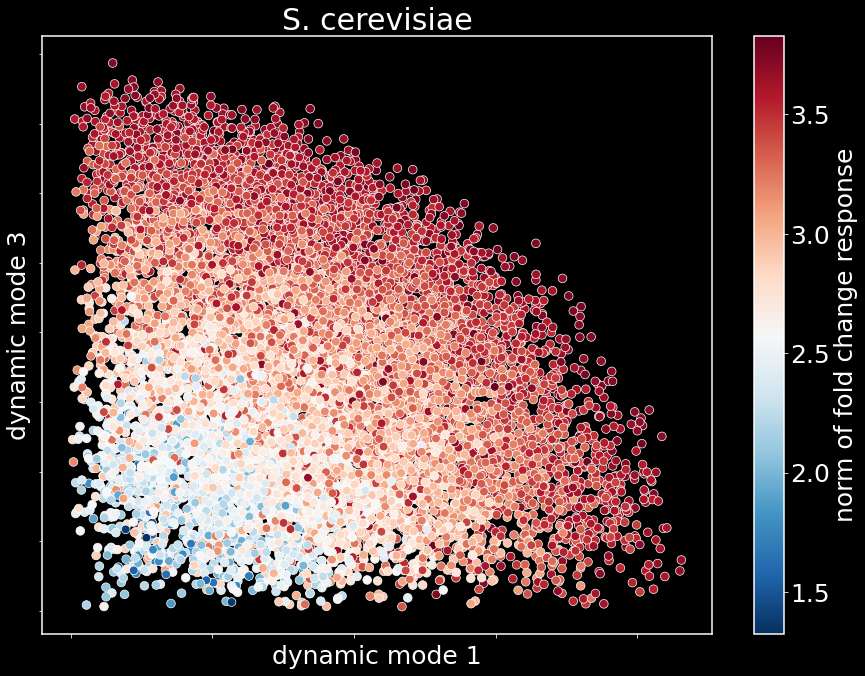

In [339]:
plt.style.use('dark_background')
# dark_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
this_cmap = 'RdBu_r'

# this_cmap = sns.diverging_palette(h_neg=22, h_pos=175, s=100, l=50, sep=40, as_cmap=True)

fig, ax = plt.subplots(figsize=(15,11))
sns.scatterplot(x=np.abs(Phi[:,0]),y=np.abs(Phi[:,2]),
                c=np.linalg.norm(np.mean(fc,axis=2),axis=1),ax=ax,s=75,cmap=this_cmap)
plt.xlabel('dynamic mode 1'); plt.ylabel('dynamic mode 3');
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('S. cerevisiae')

norm = plt.Normalize(np.linalg.norm(np.mean(fc,axis=2),axis=1).min(),
                     np.linalg.norm(np.mean(fc,axis=2),axis=1).max())
sm = plt.cm.ScalarMappable(cmap=this_cmap, norm=norm)
sm.set_array([])
ax.figure.colorbar(sm,label='norm of fold change response')

# plt.savefig('/Users/aqib/Documents/dmd_proj_yeast.pdf',bbox_inches='tight',transparent=True,dpi=300)

plt.show()